**Самостоятельная работа №2
Исследование динамических свойств
пространственных каналов беспроводной передачи данных**

⚠️ Note: В этой домашней работе вам следует опробовать предложенный алгоритм для каналов "PATH" и "SPEED", а также для канала "link_chan_2", который использовался в предыдущей домашней работе


**Введение**

До настоящего момента мы не рассматривали динамику канала во времени, производя оценку в каждый момент времени независимо. В этой работе мы попытаемся использовать предыдущие состояния для оценки канала в интересующий момент времени, предполагая, что канал медленно меняется во времени.

В предыдущей работе мы уже научились строить пространственные спектры, которые помогали оценить углы, с которых сигнал был принят по отношению к плоскости антенной решётки, а также спектр пространства задержек, который описывает физическую задержку на распространение сигнала от передатчика к приемнику. Мы понимаем, что эти спектры характеризуют не только свойства нашего сигнала, но и геометрические свойства канала (где расположены отражатели, их форма и размер). Мы также знаем, что положение отражателей фиксировано, и поэтому спектры каналов обычно сильно коррелируют в коротких интервалах.

Давайте воспользуемся этим свойством в данной домашней работе и улучшим оценку канала, используя состояния канала в предыдущие моменты времени для предсказания и выбеливания шума в будущих состояниях канала.

In [1]:
# Install modulation library
!pip install -q ModulationPy

In [2]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from ModulationPy import PSKModem, QAMModem
from tqdm.notebook import tqdm, trange
from numpy import sqrt
import itertools
plt.rcParams.update({'font.size': 15})

USE_GOOGLE_DRIVE = False
FOLDER_PATH = '/home/lexotr/my_gits/9_semester_programming/mimo/first_hw/Channels/'

# Which channel file you'd like to load
CHAN_NAME = 'link_chan_2.mat'.format('2')                                  #  <<< Set your value here

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/gdrive')
    CHAN_NAME = 'link_chan_{}.mat'.format('2')

os.chdir(FOLDER_PATH)

Возьмем "link_chan_2" в качестве примера

Number of user antennas:  4
Number of base station antennas:  64
Number of subcarriers:  256
Number of time moments:  100


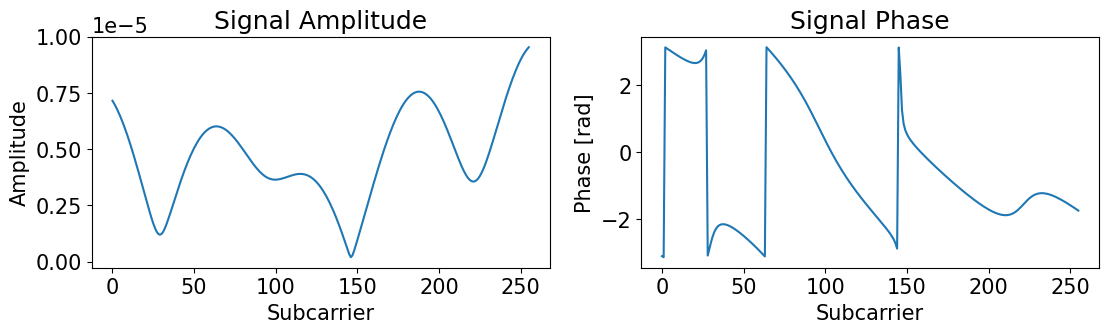

In [3]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]

N_ue_ants, N_bs_ants, N_subcarriers, N_tti = H.shape

# Some info about signal
print('Number of user antennas: ', N_ue_ants )
print('Number of base station antennas: ', N_bs_ants)
print('Number of subcarriers: ', N_subcarriers)
print('Number of time moments: ', N_tti)

# Let's plot Amplitudes and Phases over frequencies for fixed pair of antennas
# and fixed time moment (TTI)
plt.figure(figsize = (13,3))
plt.subplot(1,2,1)
plt.plot(np.abs(H[0,0,:,0]))
plt.title('Signal Amplitude'); plt.xlabel('Subcarrier'); plt.ylabel('Amplitude')

plt.subplot(1,2,2)
plt.plot(np.angle(H[0,0,:,0]))
plt.title('Signal Phase'); plt.xlabel('Subcarrier'); plt.ylabel('Phase [rad]')
plt.show()

В предыдущем домашнем задании, у нас была несколько непрактичная ситуация, когда мы использовали одни и те же ресурсы для SRS и отправки данных одновременно. В реальных системах нам приходится выделять некоторые ресурсы для пилотов и оценки канала, а другие использовать для передачи данных. Давайте рассмотрим простейший пример, моделирующий такую ​​ситуацию. Например, мы будем отправлять пилотные символы каждый 4-й TTI (TTI - Transmission time interval), а все остальные TTI использовать для данных.

In [4]:
# Number of all TTIs in our channel
N_ofdm_symb = H.shape[-1]

# Pilot spacing
spacing_pilot = 4;

# Grid with tti indices where we will send pilot symbols
pilot_positions = np.arange(start = 0,
                            stop = N_ofdm_symb,
                            step = spacing_pilot)

# Plot grid
print('Pilot TTIs:', pilot_positions)

# All other TTIs we will use for data transmission
data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)
print('Data TTIs:', data_positions)

Pilot TTIs: [ 0  4  8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 76 80 84 88 92
 96]
Data TTIs: [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35 37 38 39 41 42 43 45 46 47 49 50 51 53 54 55 57 58 59 61 62 63
 65 66 67 69 70 71 73 74 75 77 78 79 81 82 83 85 86 87 89 90 91 93 94 95
 97 98 99]


Давайте визуализируем временное распределение ресурсов нашей системы. Для этого напишем такую функцию:

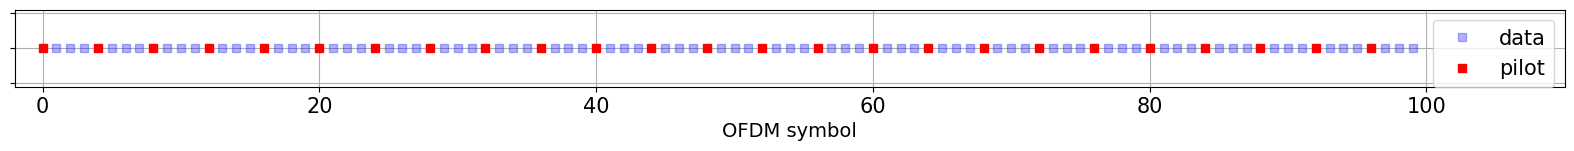

In [5]:
#Let us visualize our resources
def plot_subc(data_subc, pilot_subc):
    '''
    Plots pilot (red) and data (blue) TTI positions
    '''
    plt.figure(figsize = (20,1))
    plt.plot(data_subc, np.zeros_like(data_subc), 's',color = 'blue', label='data', alpha = 0.3, )
    plt.plot(pilot_subc, np.zeros_like(pilot_subc), 's',color = 'red', label='pilot')
    plt.xlabel('OFDM symbol', fontsize = 14)
    fr = plt.gca()
    fr.axes.yaxis.set_ticklabels([])
    plt.grid()
    plt.legend()
    plt.xlim([-2, 110])
    plt.show()

plot_subc(data_positions, pilot_positions)

Теперь создадим функции, которые нам нужны для передачи пилот-сигнала SRS. В предыдущей домашней работе мы просто загрузили последовательности SRS из файла .mat, который был сгенерирован с помощью MATLAB 5G-Toolbox. Теперь мы представляем вам реализацию последовательностей Задоффа-Чу, которые могут генерировать сигналы SRS с нашими конфигурациями. Используя такую ​​функцию, мы легко можем добиться тех же свойств взаимной корреляции, что и с загруженными пилот-сигналами SRS.

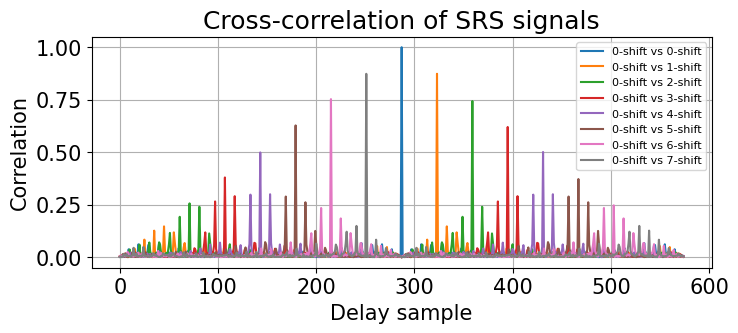

In [6]:
def ZadoffChu_gen(n_US, M_sc, ID_Ue):
    '''ZADOFFCHU_GEN Generates a Zadoff-Chu sequence used for cell search and synchronization in LTE networks.

    Inputs:
       n_US  - The number of unique sequences.
       M_sc  - The number of subcarriers.
       ID_Ue - The unique identifier for the user equipment (UE).

    Output:
       out   - The generated Zadoff-Chu sequence.
    '''

    # Configuration for Zadoff-Chu sequence generation
    N_ap = 1                                                    # Number of antenna ports

    # Length of Zadoff-Chu sequence, chosen as the max prime less than M_sc
    N_zc = max([p for p in range(2, M_sc) if all(p % n != 0 for n in range(2, p))])
    n = np.arange(N_zc)                                         # Base sequence index

    # Generate the base Zadoff-Chu sequence
    q = 10                                                      # Base root index (should be relatively prime to N_zc)
    x_q = np.exp(-2j * np.pi * q * n * (n + 1) / (2 * N_zc))
    k = np.arange(M_sc)                                         # Subcarrier indices
    r = x_q[np.mod(k, N_zc)]                                    # The sequence repeated for all subcarriers

    # Calculate the cyclic shift for the sequence
    n_rs = ID_Ue                                                # UE-specific sequence number
    p = np.arange(N_ap)                                         # Antenna port indices
    N_rs = np.mod(n_rs + n_US * p / N_ap, n_US)                 # Cyclic shift calculation
    alpha = 2 * np.pi * N_rs / n_US                             # Cyclic shift phase
    n = np.arange(len(r))                                       # Index for the final sequence

    # Initialize the output sequence matrix
    out = np.zeros((M_sc, N_ap), dtype = complex)

    # Apply the cyclic shift to generate the Zadoff-Chu sequence for each antenna port
    for index_antenna in range(len(alpha)):
        out[:, index_antenna] = np.exp(1j * alpha[index_antenna] * n) * r

    return out


def correlate_time_domain(x1, x2, normalize = True):
    '''
    Calculates cross-correlation between two signals in the time domain.
    INPUTS:
        - x1: (np.ndarray) first signal array
        - x2: (np.ndarray) second signal array
        - normalize: (bool). If 'True' then normalize result to have max amplitude equal to 1.
          if 'False' then normalization is not applied
    OUTPUTS:
        - Absolute value of cross-correlation between X1 and X2, where X1 and X2
          are inverse Fourier transform of x1 and x2 respectively.
    '''
    X1 = np.fft.ifft(x1.flatten())
    X2 = np.fft.ifft(x2.flatten())
    corr = np.correlate(X1, X2, 'full')
    abs_corr = np.abs(corr)

    if normalize:
        abs_corr /= np.max(abs_corr)
    return abs_corr


# Plot Cross-correlation of SRS signals
plt.figure(figsize = (8,3))
for i in range(8):
    c = correlate_time_domain(ZadoffChu_gen(8, 288, 0) ,ZadoffChu_gen(8, 288, i), normalize = False)
    plt.plot(c, label = '0-shift vs {0}-shift'.format(i) )

plt.ylabel('Correlation')
plt.xlabel('Delay sample')
plt.title('Cross-correlation of SRS signals')
plt.grid()
plt.legend(fontsize = 8)
plt.show()

Также возьмем некоторые другие реализованные функции из прошлого домашнего задания

In [7]:
def normalize(H):
    '''
    Normalizes the channel along UE antennas and subcarriers to have unit power on each receive antenna.
    '''
    # Shape of H
    N_ue, N_bs, N_f, N_tti = H.shape

    # Calculate norms along 0,2 axis (N_ue, N_f)
    norma = np.linalg.norm(H, ord = 'fro', axis = (0,2), keepdims = True)

    # return normalized channel
    H_normed = H / norma * sqrt(N_ue)
    return H_normed


def bit_error_rate(received_bits, true_bits):
    '''Calculates bit error rate (BER) between two-bit sequences'''

    return np.mean(np.abs(received_bits - true_bits), axis = 1)[0]


def get_noise(signal, SNR_dB):
    '''Returns complex AWGN tensor for a signal with the same shape
       satisfying SNR ratio
        Inputs:
            - signal: (np.ndarray) some signal array
            - SNR: (int) SNR value in decibels, which adjusts noise power.
                    if SNR is None, return 0 (no noise at all)
       '''
    if SNR_dB is None:
        return 0
    # complex-valued AWGN with 0 mean and unit variance with same size as @signal
    noise = np.sqrt(1/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))

    # Calculate mean @signal power
    P_signal = np.mean(np.abs(signal)**2)

    # Normalize Noise to satisfy SNR
    noise_normed = noise * sqrt(10**(-SNR_dB/10) * P_signal)
    return noise_normed


Cделаем важное замечание касательно того, как генерировать шум в случае с изменяющимся во времени каналом. В настоящей системе шум зависит от размера полосы частот и от температуры приемника. В то же время уровень сигнала постоянно меняется со временем, что означает что значение SNR также меняется. Для того чтобы исследовать разные алгоритмы под влиянием белого шума, в предыдущей работе мы фиксировали уровень SNR. Поскольку наш алгоритм обрабатывал сигналы независимо для каждого момента времени, мы нормировали уровень шума для каждого временного промежутка (TTI), для того чтобы получить фиксированный SNR. Однако, мы не можем использовать этот подход в данной работе, так как мы хотим создать алгоритм, который будет использовать состояния канала в разные моменты времени. В таком случае, нам надо взять средний уровень SNR для 100 TTI для того чтобы иметь одинаковый уровень шума для разных моментов времени. Это будет сделано следующим образом:

1.   Мы сгенерируем идеальный сигнал на приемнике для 100 TTI
2.   Рассчитаем среднюю мощность принятого сигнала
3.   Сгенерируем и зададим уровень шума в соответствии со значением SNR


In [8]:
def receiver_signal(H, X):
    '''
    Models ideal signal at the receiver side.

    INPUTS:
        - H (np.ndarray): channel tensor with shape of [N_ue_ants x N_bs_ants x N_subcarrier]
        - X (np.ndarray): transmitted signal matrix with shape of [N_bs_ants x N_subcarrier]
    '''
    N_ue, N_bs, N_f = H.shape

    y = np.zeros((N_ue, N_f), dtype = np.complex128)

    for f in range(N_f):
        y[:, f] = H[:,:,f] @ X[:,f]

    return y

In [9]:
def equalize(Y, H_est):
    '''
    Recovers signal that was transmitted using received signal and estimated channel.
    Output has shape of [rank x N_subcarriers]
    INPUTS:
        - Y: received signal with chape of [N_ue_ants x N_subcarriers x N_tti]
        - H_est: estimated effective channel with shape of [N_ue_ants x rank x N_subcarrires x N_tti]
    '''
    # Y in [N_tti x N_bs x N_f x 1*]
    # H_est [ 1* x N_bs x N_f x N_tti]

    if len(Y.shape) < 4:
        Y = np.expand_dims(Y, 2)

    if (len(H_est.shape) == 4) and (H_est.shape[0] > 1):
        raise NotImplementedError("This work support only single ue antenna")
    if len(H_est.shape) < 4:
        H_est = np.expand_dims(H_est, 0)

    N_ue, N_bs, N_f, N_t = H_est.shape

    s_est = np.zeros((1, N_f, N_t), dtype = np.complex128)

    H_first_ue = H_est[0]
    for t in range(N_t):
        for f in range(N_f):
            H_to_pinv_from = H_first_ue[:, None, f, t]
            W_equalizer = np.linalg.pinv(H_to_pinv_from)
            Y_arr = Y[t, ..., f]
            # print(W_equalizer.shape, Y_arr.shape)
            res =  W_equalizer @ Y_arr
            s_est[0, f, t] = res[0,0]

    return s_est

В этой работе нам предстоит разобраться детальнее, что происходит в блоке оценки канала. Давайте разберем проcтейший пример

In [10]:
H = normalize(H)

N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape

spacing_pilot = 4          # Pilot spacing. You may need to change it.

pilot_positions = np.arange(start = 0,
                            stop = N_ofdm_symb,
                            step = spacing_pilot)


data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)

N_data_ofdm_symb = len(data_positions)  # Number of time moments

# Some configuration from previous HW
N_layers = 1
N_constellation_points = 16
N_bits_per_conts_point = int(np.log2(N_constellation_points))
modem = QAMModem(M = N_constellation_points,
                 bin_input = True,
                 gray_map = True,
                 soft_decision = False,
                 bin_output = True)
constellation_norm = (2/3 * (N_constellation_points - 1))**0.5


Чтобы не запутаться в размерностях массивов во время симуляций, будем хранить информацию о пользователе в словаре. В следующей домашней работе, когда у нас будет много пользователей, это существенно упростит чтение кода. Также для простоты, мы зафиксируем число антенн на пользователе до 1.

In [11]:
# User specific dictionary. Write to it bits, modulated symbols, user-specific pilots
ue = dict(bits = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers, N_bits_per_conts_point)),
          symbs = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers), dtype = np.complex128),
          pilot_symb = ZadoffChu_gen(1, N_subcarriers, 0)
        )

# Arrays for received signal
Y_target = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)
Y_target_noisy = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)
# Resource allocation block
data_index = 0
for t in range(N_ofdm_symb):                # go along time moments axis

    if t in pilot_positions:                # if current tti for pilot
        current_symb = ue['pilot_symb'].T   # write pilot signal

    elif t in data_positions:               # if current tti for data
        # generate data and add to current symbol
        bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
        ue['bits'][data_index] = bits
        ue['symbs'][data_index] = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm
        current_symb = ue['symbs'][data_index]
    else:
        raise Exception("Ofdm symbol {0} doesn't exits in data_positions or pilot_positions")

    H_t = H[0, :, None,:, t]                            # channel slice with 1 UE antenna
    Y_target[t] += receiver_signal(H_t, current_symb)   # received signal
    if t in data_positions: data_index += 1             # increase counter

# Now we can add some noise to received signal if we need it
snr_dB = -20

Y_target_noisy = Y_target + get_noise(Y_target, SNR_dB = snr_dB)

print("RX signal shape:", Y_target_noisy.shape)

RX signal shape: (100, 64, 256)


Теперь зная пилотный сигнал мы можем попытаться восстановить оценку канала в моменты, где мы передавали SRS. После LS оценки мы хотим избавиться от шума и интерференции (если она присутствует), для этого используем оконный фильтр.

In [12]:
N_ofdm_symb, N_bs_ants, N_subcarriers = Y_target.shape
pilots = ue['pilot_symb'].flatten()
H_est = np.zeros((1, N_bs_ants, N_subcarriers, N_tti), dtype = np.complex64)

for pilot_pos in pilot_positions:
    # LS estimation
    h_ls = Y_target[pilot_pos] * (pilots.conj().T)  # <<< Use noisy signal in your simulations !!!

    # Windowing. You may use this algorithm for windowing, or any other.
    W_win = N_subcarriers // 8
    h_ls = np.fft.ifft(h_ls, axis = -1, norm = 'ortho')
    h_ls[:, W_win:] = 0
    h_ls = np.fft.fft(h_ls, axis = -1, norm = 'ortho')

    H_est[..., pilot_pos] = h_ls


Оценка канала практически готова. Нам осталось найти её в моменты времени, где мы передаём данные. Для этого мы должны экстраполировать каждый раз оценку канала по пилотным сигналам. Реализуем это и визуализируем результаты

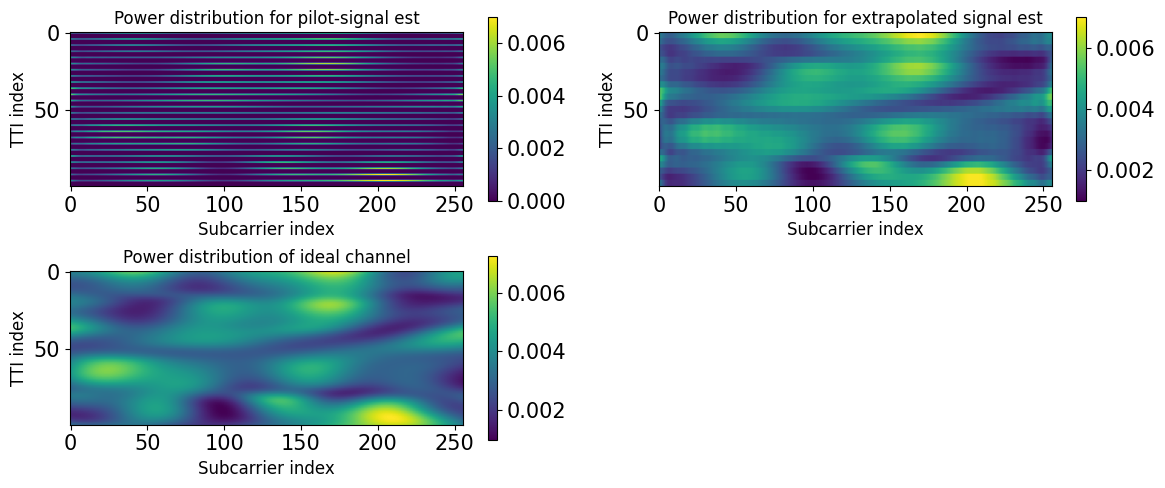

In [13]:
H_est_full = np.zeros_like(H_est)

for ant_bs_index in range(N_bs_ants):
    for sc_index in range(N_subcarriers):
        # Extract the channel estimate for the current subcarrier
        H_slice = H_est[0, ant_bs_index, sc_index, pilot_positions]

        # Perform linear interpolation across symbols
        F = scipy.interpolate.interp1d(pilot_positions, H_slice, kind = 'previous', fill_value='extrapolate')

        # Apply the interpolation to estimate the channel across all symbols
        H_est_full[0, ant_bs_index, sc_index, :] = F(np.arange(N_ofdm_symb))

# This is a signal which we have after channel estimation
plt.figure(figsize = (12,5))
plt.subplot(2,2,1)
plt.imshow(np.mean(np.abs(H_est[0])**2, axis = 0).T)
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution for pilot-signal est', fontsize = 12)
plt.colorbar()

# This is a signal which obtained using interpolation of the previous image
plt.subplot(2,2,2)
plt.imshow(np.mean(np.abs(H_est_full[0])**2, axis = 0).T)
plt.colorbar()
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution for extrapolated signal est', fontsize = 12)

# This is ideal signal
plt.subplot(2,2,3)
plt.imshow(np.mean(np.abs(H[0])**2, axis = 0).T)
plt.colorbar()
plt.xlabel('Subcarrier index', fontsize = 12); plt.ylabel('TTI index', fontsize = 12)
plt.title('Power distribution of ideal channel', fontsize = 12)
plt.tight_layout()

Объединив код можем получить функцию для оценки канала, в которую вам дальше необходимо будет добавить VAR фильтр, который скоро будет представлен

# Преобразование в пространство задержек и лучей
Пусть имеется оценка канала  $\mathrm{H}(t) \in \mathbb{C}^{N\times K}$, где $N$ - количество антенн на базовой станции, $K$ - количество поднесущих в момент времени $t$. Представим исходный канал в пространстве задержек и лучей $\mathrm{Z(t)}$ с помощью преобразования 𝔉, которое представляет собой умножение матрицы канала на ДПФ с двух сторон::
$$
\mathop{\mathrm{Z(t)}}_{B \times D} = 𝔉(\mathrm{H(t)}) = \mathop{\mathrm{F_B}}_{B\times N}\mathop{\mathrm{H(t)}}_{N\times K}\mathop{\mathrm{F^H_D}}_{K \times D}
$$
Здесь $D$ и $B$ это количество задержек (Delays) и лучей (Beams). В нашем случае предположим, что $B = N$ и $D = K$, таким образом размер матрицы канала не изменится.

${\mathrm{F^H_D}}$ - матрица преобразования поднесущих в задержки, представляющая собой матрицу ДПФ, а $\mathrm{F_B}$ - матрица преобразования пространства антенн в пространство  лучей, которая зависит от структуры антенной решётки и может быть представлена в виде произведения Кронекера двух ДПФ матриц ($F_{hor}$ , $F_{ver}$) размер которых определяется числом антенных элементов по вертикали/горизонтали и единичной матрицы $I_{pol}$, учитывающей поляризацию антенных элементов:
$$
\mathrm{F_B} = \mathrm{I_{pol}} ⊗ \mathrm{F_{ver}} ⊗ \mathrm{F_{hor}}
$$
Где ⊗ - произведение Кронекера, и $\mathrm{I}_{pol}$ это 2x2 единичная матрица (2 - количество состояний поляризаций), $\mathrm{F}_{hor}$ это 8x8 ДПФ матрица (8 - количество горизонтально расположенных антенных элементов) и $\mathrm{F}_{ver}$ это 4x4 ДПФ матрица (4 - количество вертикально расположенных антенных элементов)

## Векторная авторегрессия
Необходимость трансформации канала в пространство задержек и лучей заключается в том, что позиции задержек и лучей изменяются гораздо медленней, чем коэффициенты самого канала. Более того, представление сигнала в этих пространствах более разреженное, что позволяет снизить вычислительную сложность, поскольку можно обрабатывать только самые энергетически сильные компоненты.

Итак, имеем представление канала в пространстве задержек и углов на каждой в момент времени $t$:

$$
\mathop{\mathrm{Z}(t)}_{B \times D} = \mathrm{[z_1(t) , ..., z_D(t)]}
$$
где $\mathrm{z_{\tau}}\in \mathbb{C}^{B}$ - угловой спектр на задержке $\tau \in {\{1,2,...,D\}}$

Теперь мы бы хотели разработать модель, которая описывает угловой спектр для определенной задержки в текущий момент времени $t$ как линейную комбинацию угловых спектров (в ту же самую задержку) в $N_p$ предыдущих моментах времени. Такая модель называется векторной авторегрессией (VAR) и записывается как:

$$
\mathrm{z_{\tau}}(t) = \mathrm{a_0} + \sum_{i=1}^{N_p}\mathrm{A_iz_{\tau}(t-i) + ϵ_t}
$$
Где $\mathrm{z_{\tau}}(t) \in \mathbb{C}^{B} - $ угловой спектр в текущий момент времени (на определенной задержке $\tau$),    $\mathrm{z_{\tau}}(t-i) \in \mathbb{C}^{B} - $ угловой спектр в предыдущий $(t-i)$-ый момент времени,    $\mathrm{A_i} \in \mathbb{C}^{B \times B} -$ коэффициенты авторегрессионной модели,  $\mathrm{a_0} \in \mathbb{C}^{B} - $ вектор смещения (bias),  и $ϵ_t \in \mathbb{C}^{B} - $ остаточная ошибка модельного представления.

В такой постановке коэффициенты авторегрессии $\mathrm{A_i}$ и $\mathrm{a_0}$ являются неизвестными величинами, которые необходимо оценить.
Для упрощения, вместо матрицы $\mathrm{A_i}$, для каждого $\mathrm{z_{\tau}}(t-i)$ мы можем использовать некоторую константную величину $a_i$, в таком случае наша задача реформулируется следующим образом:

$$
\mathrm{z_{\tau}}(t) =
\begin{bmatrix}
\mathrm{z_{\tau}}(t-1) & \mathrm{z_{\tau}}(t-2) & ... & \mathrm{z_{\tau}}(t-N_p)
\end{bmatrix}  
\begin{bmatrix}
a_{\tau}(1) \\
a_{\tau}(2) \\
... \\
a_{\tau}(N_p)
\end{bmatrix}
+ ϵ_t = \mathrm{B}_{\tau}\mathrm{a_{\tau}} + ϵ_t
$$

Здесь матрица $\mathrm{B}_{\tau} \in \mathbb{C}^{B \times N_p}$ содержит состояния канала в задержке $\tau$ на предыдущих $N_p$ временных отчётах, тогда как вектор $\mathrm{a_{\tau}} \in \mathbb{C}^{N_p \times 1}$ - это коэффициенты регрессии, которые необходимо найти. Такое уравнение имеет единственное решение:
$$
\mathrm{a_{\tau}} = \mathrm{(B_{\tau}^HB_{\tau} + γI)^{-1}B_{\tau}z_{\tau}} = \mathrm{B_{\tau}^† z_{\tau}}
$$
Здесь $†$ это псевдообратная матрица и множитель γ представляет собой регуляризацию для более стабильного обращения корреляционной матрицы.
Финальная оценка углового спектра в текущий момент времени:
$$
\mathrm{\hat{z}_{\tau}}(t) = \mathrm{B_{\tau}a_{\tau}}
$$
Обращаем внимание, что для каждой задержки $\tau$ мы предполагаем наличие своего отдельного фильтра  $B_{\tau}$

Для получения оцененного VAR-моделью канала в исходных пространствах необходимо получить VAR-оценку $Z(t)$ на всех поднесущих:
$$
\mathrm{\hat{Z}(t)} = [ \mathrm{\hat{z}_{1}(t)} ,...,  \mathrm{\hat{z}_{D}(t)}]
$$

## Преобразование в пространство Антенн и поднесущих частот
В конечном итоге, необходимо осуществить обратное преобразование сигнала из пространства задержек и лучей в пространство антенн и поднесущих частот. Это можно сделать, используя те же матрицы что и для преобразования в лучи и задержки:
$$
\mathrm{\hat{H}}(t) = 𝔉^{-1}(\mathrm{\hat{Z}(t)}) = \mathrm{F_B^H}\mathrm{\hat{Z}(t)}\mathrm{F_D}
$$

Теперь реализуем авторегрессионный фильтр в виде отдельного класса:

In [14]:
import scipy.linalg
import scipy.sparse


class VAR_filter():
    def __init__(self, N_hor, N_ver, N_pol, N_delay, memory_size) -> None:
        '''
        Initialization method for VAR filter.
        INPUTS:
            - N_hor: (int) number of horizontaly placed antenna elements
            - N_ver: (int) number of vertically placed antenna elements
            - N_pol: (int) number of polarzations
            - N_delay: (int) number of Delays in the signal (equal to number of subcarriers)
            - memory_size: (int) Defines how many beams spectrums to use for estimation
        '''

        # Here create DFT, I matrices for Beam domain transfrom (you can use scipy.linalg.dft)
        F_h = np.fft.fft(np.eye(N_hor)) # YOUR CODE HERE
        F_v = np.fft.fft(np.eye(N_ver)) # YOUR CODE HERE
        I_p = np.eye(N_pol)# YOUR CODE HERE
        # I_p = I_p / np.linalg.norm(I_p)
        # F_h = F_h / np.linalg.norm(F_h)
        # F_v = F_v / np.linalg.norm(F_v)

        # Calculate Beam domain transfrom using kron
        self.F_b = np.kron(np.kron(I_p, F_v), F_h) # YOUR CODE HERE
        # self.F_b = np.kron(np.kron(F_h, F_v), I_p) # YOUR CODE HERE
        self.F_b = self.F_b / np.sqrt(N_hor * N_ver)
        # self.F_b = self.F_b / np.linalg.norm(self.F_b, ord="fro")
        # print(np.linalg.norm(self.F_b, ord="fro"))
        # self.F_b = np.kron(np.kron(I_p, F_v), F_h) # YOUR CODE HERE

        # Create IDFT matrix as Delay domain transfrom
        self.F_d = np.fft.fft(np.eye(N_delay))# YOUR CODE HERE
        self.F_d = self.F_d / np.sqrt(N_delay)
        # print(np.linalg.norm(self.F_d, ord="fro"))
        # self.F_d = self.F_d / np.linalg.norm(self.F_d)
        # print(np.linalg.norm(self.F_d, ord="fro"))

        # print(f"Shapes: F_b: {self.F_b.shape}, F_d: {self.F_d.shape}")

        self.memory_size = memory_size
        N_bs_ants = N_hor*N_ver*N_pol
        self.gamma = 1

        # VAR coefficient filters
        self.coeff = np.zeros((N_delay, N_bs_ants, memory_size), dtype= np.complex128)
        self.taken_coeffs = 0


    def to_beam_delay(self, H):
        '''
        Tranfroms channel matrix H from antenna frequency domain into beam-delay domain
        INPUTS:
            - H (np.ndarray): channel matrix with shape of N_bs_ants x N_subcarriers
        '''
        return np.matmul(np.matmul(self.F_b, H), self.F_d.conj().T)# YOUR CODE HERE


    def to_antenna_frequency(self, Z):
        '''
        Tranfroms Beam-Dealy channel representation matrix Z to antenna frequency domain.
        INPUTS:
            - z (np.ndarray): channel matrix with shape of N_beams x N_delays
        '''

        return np.matmul(np.matmul(self.F_b.conj().T, Z), self.F_d)# YOUR CODE HERE


    def estimate(self, H, update_coeff:bool):
        '''
        VAR channel estimation function in applied for beam domain.
        INPUTS:
            - H (np.ndarray): channel matrix with shape of N_bs_ants x N_subcarriers
            - update_coeff (bool): If True then adds current channel H into filter memory
        '''

        assert len(H.shape) == 2 , 'only matrix is assumed here'

        # Allocate memory for VAR estimated channel
        Z_est = np.zeros_like(H)

        # Transform signal to Beam-Delay domain
        Z = self.to_beam_delay(H)# YOUR CODE HERE

        if self.taken_coeffs == 0:
            if update_coeff == True:
                self.update_coeffs(Z)
            return H

        # For each tap do required processing
            # ====================================
            # YOUR CODE HERE
            # ====================================
        for i in range(Z.shape[1]):
            z_cur = Z[:, [i]]
            # column_start = max(0, i - self.memory_size)
            B_tau = self.coeff[i, :, :]
            inv_mat = np.linalg.pinv(B_tau)

            # BH_B = np.matmul(B_tau.conj().T, B_tau)
            # inv_mat = np.matmul(np.linalg.inv(BH_B + self.gamma * np.eye(self.memory_size)), B_tau.conj().T)

            a_tau = np.matmul(inv_mat, z_cur)
            Z_est[:, [i]] = np.matmul(B_tau, a_tau)

        # If we need to update VAR filter coeffs
        if update_coeff == True:
            self.update_coeffs(Z)
            # Call update
            # YOUR CODE HERE

        # Apply antenna - frequency transform
        H_est = self.to_antenna_frequency(Z_est)
        # H_est = H_est / np.linalg.norm(H_est)
        return H_est

    def update_coeffs(self, Z):
        '''
        This function adds current beam spectrum into filter
        Attention: be careful with the position of inserting new observations!
        INPUTS:
            - Z (np.ndarray): beam-delay matrix of channel, that will be stored in filter. Shape: [N_beams x N_delays]
        '''

        # YOUR CODE HERE
        # shift coeffs
        if self.taken_coeffs < self.memory_size:
            self.coeff[..., self.taken_coeffs] = Z.T
            self.taken_coeffs += 1
        else:
            # print(self.coeff.shape)
            self.coeff = np.roll(self.coeff, -1, axis=2)# YOUR CODE HERE
            self.coeff[..., self.memory_size - 1] = Z.T
        # insert new coeffs



# QUESTIONS:

# What to do with first z, e.g z(0) (Just call update and thats it? Seems the only solution)

# How to actually filter?? just call this thing on h_ls?

# Do we correct the current h_ls, or somehow the future? The latter seems impossible, because of need in z(t) in formulas

# When to call update? On every h_ls approximation?



In [15]:
Y_target.shape

(100, 64, 256)

In [16]:
def channel_estimation(Y_target, ue, pilot_positions, win_width = 32, interp_type = 'previous', filt_object=None):
    '''
    Performs channel estimation using received and transmitted pilots.
    Also performs channel interpolation for full resource grid.

    INPUTS:
        - Y_target - received pilot symbols with shape of  [N_ofdm_symb x N_bs_ants xN_subcarriers]
        - ues - (list) list with target UE dictionaries
        - pilot_positions - array with TTI indices where pilots was transmitted
    OUTPUT:
        - H_est_full - denoised and interpolated channel estimation for all resources.
    '''
    N_ofdm_symb, N_bs_ants, N_subcarriers = Y_target.shape
    pilots = ue['pilot_symb'].flatten()
    H_est = np.zeros((1, N_bs_ants, N_subcarriers, N_tti), dtype = np.complex64)

    for pilot_pos in pilot_positions:
        # LS estimation
        h_ls = Y_target[pilot_pos] * (pilots.conj().T)

        # Windowing. You may use this algorithm for windowing, or any other.
        if win_width != None:
            W_win = win_width
            h_ls = np.fft.ifft(h_ls, axis = -1, norm = 'ortho')
            h_ls[:, W_win:] = 0
            h_ls = np.fft.fft(h_ls, axis = -1, norm = 'ortho')
        
        if not (filt_object is None):
            h_ls = filt_object.estimate(h_ls, True)


        # ===========================================================================
        # Here you may use VAR filter, that will be implemented soon.
        #
        # ===========================================================================

        H_est[..., pilot_pos] = h_ls

    # Interpolation block
    if interp_type != None:
        H_est_full = np.zeros_like(H_est)

        for ant_bs_index in range(N_bs_ants):
            for sc_index in range(N_subcarriers):
                # Extract the channel estimate for the current subcarrier
                H_slice = H_est[0, ant_bs_index, sc_index, pilot_positions]

                # Perform linear interpolation across symbols
                F = scipy.interpolate.interp1d(pilot_positions, H_slice, kind = interp_type, fill_value='extrapolate')

                # Apply the interpolation to estimate the channel across all symbols
                H_est_full[0, ant_bs_index, sc_index, :] = F(np.arange(N_ofdm_symb))
        return H_est_full
    return H_est

Теперь мы можем отрисовать зависимость мощности оценённого и идеального канала от времени. Здесь мы будем использовать самую простую функцию для интерполяции: повторение последней оценки по пилоту до тех пор, пока не придет новый пилот, так что наша оценка "прыгает" ближе к идеальной каждый раз, когда мы получаем новый пилот.

На этом шаге мы можем попробовать использовать различные функции интерполяции для восстановления данных (будет частью этой домашней работы)

Однако, наш оценённый по пилоту сигнал все ещё содержит остаточный шум. Для того, чтобы избавиться от этого шума, мы можем ограничить свойства оценок канала по оси  времени! В простейшем случае мы предполагаем использовать авторегрессию для ограничения наших оценок, предполагая, что канал медленно меняется со временем.

In [17]:
Y_target.shape

(100, 64, 256)

In [18]:
H.shape

(4, 64, 256, 100)

(4, 64, 256, 100)
[0.03037242 0.02980868 0.02931109 0.0288572  0.02843572 0.02804158
 0.02767266 0.02732803 0.02700807 0.02670884 0.02640103 0.0260533
 0.02564501 0.02519654 0.02480734 0.02456437 0.02450033 0.02459374
 0.02483111 0.02517661 0.02555294 0.02587252 0.02612705 0.02633553
 0.02650512 0.02662574 0.02670197 0.02675074 0.02678817 0.02681993
 0.02683479 0.02682707 0.0268028  0.02677808 0.02675567 0.02671052
 0.02659221 0.02635757 0.02604651 0.02571219 0.02538754 0.02508893
 0.02485213 0.02470808 0.02466837 0.0247207  0.02482816 0.02495027
 0.0250471  0.0250896  0.02508438 0.02505343 0.02502404 0.02503141
 0.02512239 0.02531995 0.02560674 0.02593777 0.02629912 0.02667104
 0.02701223 0.02727662 0.02746404 0.02759767 0.02770192 0.02778919
 0.0278504  0.02788171 0.02788814 0.02787426 0.02782211 0.0277154
 0.02755125 0.02734164 0.02709635 0.02682544 0.02655194 0.02634078
 0.02629649 0.02644406 0.02669198 0.02689686 0.02705398 0.02719005
 0.02729288 0.02731522 0.02725912 0.02716628 0

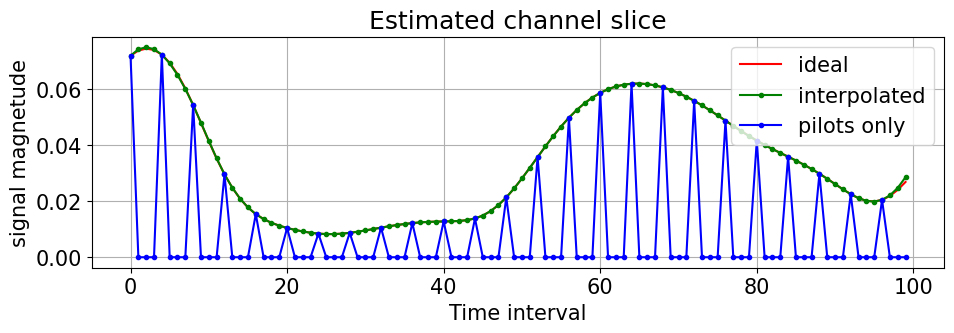

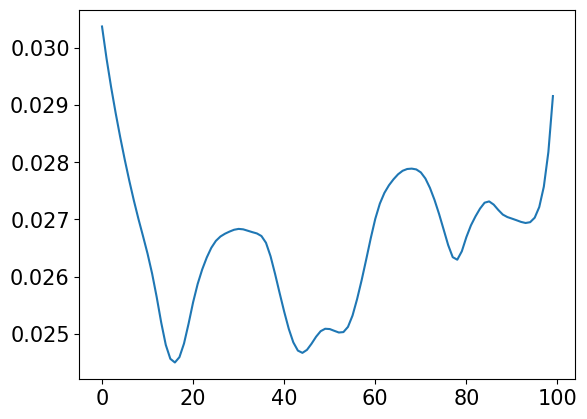

In [19]:
window_size = 10

filt = VAR_filter(4, 8, 2, N_subcarriers, window_size)

H_est_pilot = channel_estimation(Y_target, ue, pilot_positions, None, None, None)
filt = VAR_filter(4, 8, 2, N_subcarriers, window_size)
H_est_interp = channel_estimation(Y_target, ue, pilot_positions, None, 'cubic', None)

print(H.shape)
mse_value = np.sum(np.square(np.abs(H - H_est_interp)), axis=(0, 1, 2)) * H.shape[-1] * H.shape[0] / H.size

plt.figure(figsize=(11,3))
time_mom = 10
plt.plot(np.abs(H[0,0,time_mom]),'r', label = 'ideal')
plt.plot(np.abs(H_est_interp[0,0,time_mom]), '.-g', label = 'interpolated')
plt.plot(np.abs(H_est_pilot[0,0,time_mom]), '.-b', label = 'pilots only')
plt.legend()
plt.xlabel('Time interval'); plt.ylabel('signal magnetude')
plt.title('Estimated channel slice')
plt.grid()

plt.figure()
print(mse_value)
plt.plot(mse_value)

In [20]:
def test_var(H):
    h_test = H[0, ..., 3]
    h_test_tens = np.tile(h_test, (3, 1, 1))
    mem_size = 8
    filt = VAR_filter(8, 4, 2, 256, mem_size)
    starting = np.linalg.norm(h_test)
    print(starting)
    for i in range(mem_size + 2):
        h_ls = H[0, ..., i]
        res = filt.estimate(h_ls, True)
        print(np.linalg.norm(res) / starting)
    print(h_test.shape)

In [21]:
test_var(H)

8.157945649055996
1.0495957811966339
1.0337830301863349
1.0189301482016162
0.9999973898245549
0.9807251955935797
0.961986084912916
0.944181861624473
0.9274814692796751
0.9119764243527086
0.8977704463617969
(64, 256)


In [22]:
del H, N_bits_per_conts_point, spacing_pilot, pilot_positions, data_positions, Y_target, Y_target_noisy

In [23]:
H = scipy.io.loadmat(CHAN_NAME)['Link_Channel'][:,:,:256,:]
H = normalize(H)

In [24]:
def prepare_Y(H, spacing_pilot, snr_dB):
    H = normalize(H)

    N_ue_ants, N_bs_ants, N_subcarriers, N_ofdm_symb = H.shape

    pilot_positions = np.arange(start = 0,
                                stop = N_ofdm_symb,
                                step = spacing_pilot)

    data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)

    N_data_ofdm_symb = len(data_positions)  # Number of time moments

    # Some configuration from previous HW
    N_layers = 1
    N_constellation_points = 16
    N_bits_per_conts_point = int(np.log2(N_constellation_points))
    modem = QAMModem(M = N_constellation_points,
                    bin_input = True,
                    gray_map = True,
                    soft_decision = False,
                    bin_output = True)
    constellation_norm = (2/3 * (N_constellation_points - 1))**0.5

    ue = dict(bits = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers, N_bits_per_conts_point)),
            symbs = np.zeros((N_data_ofdm_symb, N_layers, N_subcarriers), dtype = np.complex128),
            pilot_symb = ZadoffChu_gen(1, N_subcarriers, 0)
            )

    # Arrays for received signal
    Y_target = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)
    Y_target_noisy = np.zeros((N_ofdm_symb, N_bs_ants, N_subcarriers), dtype = np.complex128)

    # Resource allocation block
    data_index = 0
    for t in range(N_ofdm_symb):                # go along time moments axis

        if t in pilot_positions:                # if current tti for pilot
            current_symb = ue['pilot_symb'].T   # write pilot signal

        elif t in data_positions:               # if current tti for data
            # generate data and add to current symbol
            bits = np.random.binomial(n = 1, p = 0.5, size = (N_layers, N_subcarriers, N_bits_per_conts_point))
            ue['bits'][data_index] = bits
            ue['symbs'][data_index] = modem.modulate(bits.flatten()).reshape(N_layers, N_subcarriers) / constellation_norm
            current_symb = ue['symbs'][data_index]
        else:
            raise Exception("Ofdm symbol {0} doesn't exits in data_positions or pilot_positions")

        H_t = H[0, :, None,:, t]                            # channel slice with 1 UE antenna
        Y_target[t] += receiver_signal(H_t, current_symb)   # received signal
        if t in data_positions: data_index += 1             # increase counter


    Y_target_noisy = Y_target + get_noise(Y_target, SNR_dB = snr_dB)

    return ue, Y_target, Y_target_noisy


In [33]:
def var_filter_investigation(H, spacing_pilot, snr_dB, interp = 'previous', mem_size=8, to_plot=False):
    ue, Y_target, Y_target_noisy = prepare_Y(H, spacing_pilot, snr_dB)
    pilot_positions = np.arange(start = 0,
                                stop = N_ofdm_symb,
                                step = spacing_pilot)
    data_positions = np.setdiff1d(np.arange(N_ofdm_symb), pilot_positions)

    N_ue, N_bs, N_subcarriers, N_tti = H.shape
    var_filt = None
    if mem_size != 0:
        var_filt = VAR_filter(8, 4, 2, N_subcarriers, mem_size)

    H_est = channel_estimation(Y_target_noisy, ue, pilot_positions, None, interp, var_filt)

    mse_value = np.sum(np.square(np.abs(H - H_est)), axis=(0, 1, 2)) * H_est.shape[-1] / H_est.size

    # print(Y_target_noisy[data_positions].shape, H_est[..., data_positions].shape)
    S_est = equalize(Y_target_noisy[data_positions], H_est[..., data_positions])
    S_est = np.rollaxis(S_est, 2, 0)
    # print(f"S shape {S_est.shape}")
    # print(ue['symbs'])

    # estimated bit sequence observed with noise
    est_bits  = modem.demodulate(S_est.flatten() * constellation_norm)
    true_bits = modem.demodulate(ue['symbs'].flatten() * constellation_norm)
    # print(f"est bits shape {est_bits.shape}")
    # print(f"bits reshaped {bits.reshape(1,-1).shape}")
    # print(est_bits.shape)
    ber = np.mean(np.abs(est_bits - true_bits))
    # print(f"res shape {res.shape}, {res}")
    if to_plot:
        plt.figure(figsize=(11,3))
        plt.plot(np.abs(H[0,0,10]),'r', label = 'ideal')
        plt.plot(np.abs(H_est[0,0,10]), '.-g', label = 'interpolated')
        plt.legend()
        plt.xlabel('Time interval'); plt.ylabel('signal magnetude')
        plt.title('Estimated channel slice')
        plt.grid()
    return mse_value, ber
    

In [77]:
def simulate(H, pilot_spacing = 4, interp = "previous", mem_size = 0, to_plot=False):
    snr_vals = np.arange(-25, 10, 5)
    mse_avg = np.zeros(snr_vals.size)
    mse_vals = np.zeros((snr_vals.size, H.shape[-1]))
    ber_arr = np.zeros(snr_vals.size)

    for i, snr_val in enumerate(snr_vals):
        mse_vals[i], ber_arr[i] = var_filter_investigation(H, pilot_spacing, snr_val, interp, mem_size, to_plot=to_plot)
        mse_avg[i] = np.average(mse_vals[i])
        if to_plot:
            plt.figure(figsize=(11,3))
            plt.title(f"SNR = {snr_val}")
            plt.plot(mse_vals[i])

    if to_plot:
        plt.figure()
        plt.title(f"Average MSE(SNR), spacing = {pilot_spacing}, interpolation = {interp}, memory size = {mem_size}")
        plt.xlabel("SNR")
        plt.ylabel("MSE")
        plt.grid()
        plt.plot(snr_vals, mse_avg)

        plt.figure()
        plt.title(f"BER(SNR), spacing = {pilot_spacing}, interpolation = {interp}, memory size = {mem_size}")
        plt.xlabel("SNR")
        plt.ylabel("BER")
        plt.yscale('log')
        plt.grid()
        plt.plot(snr_vals, ber_arr)
    return mse_vals, ber_arr

In [117]:
simulate(H=H, interp="previous", mem_size=0, to_plot=False)

KeyboardInterrupt: 

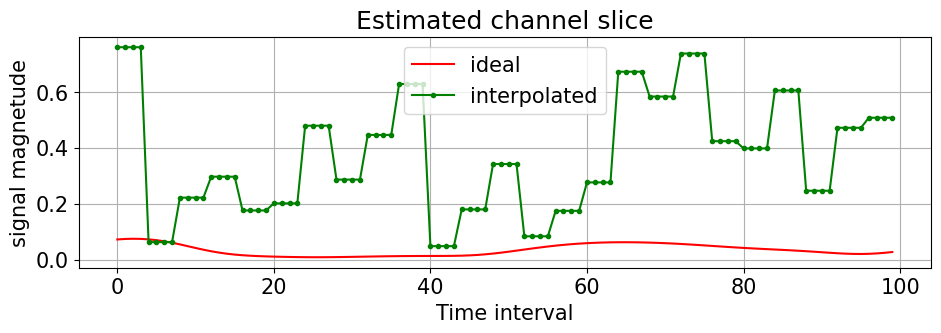

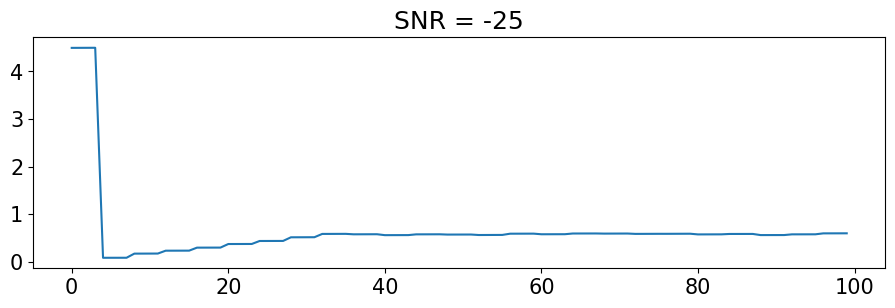

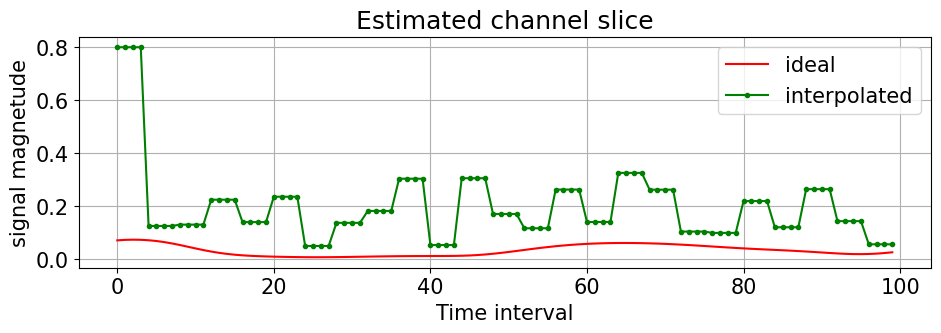

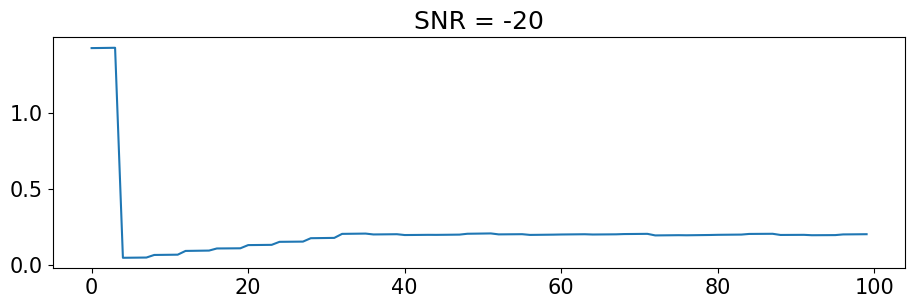

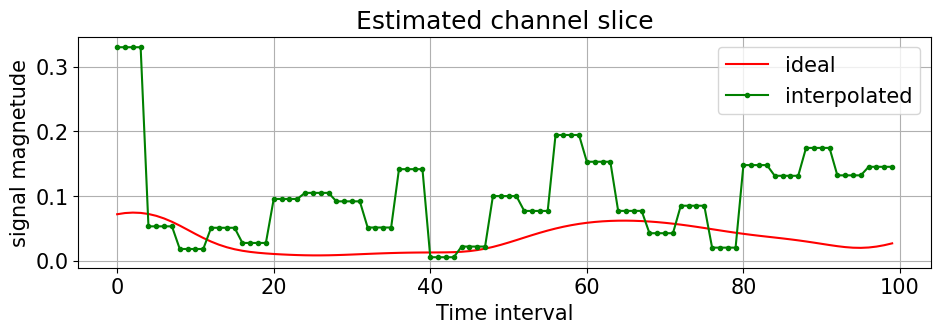

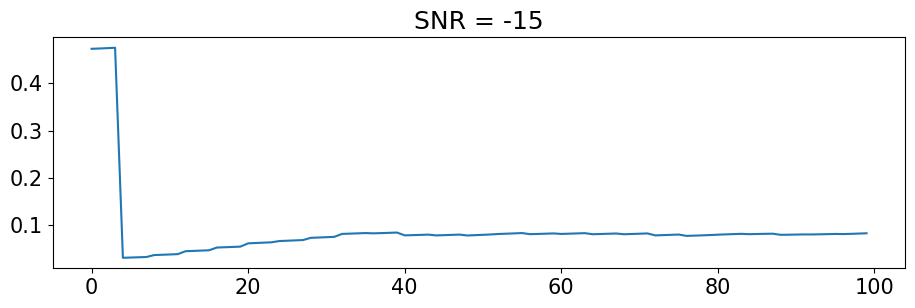

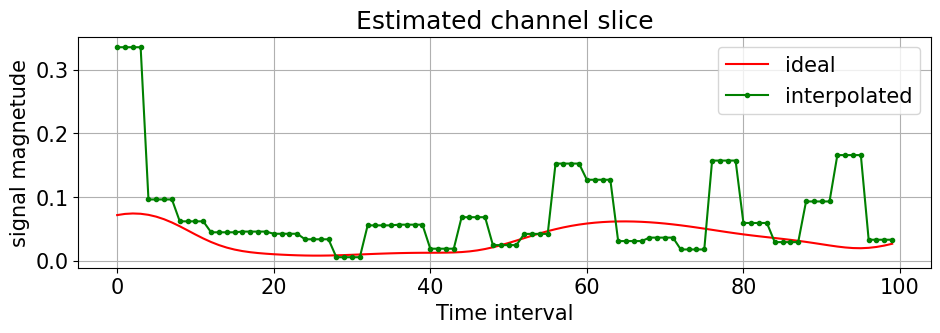

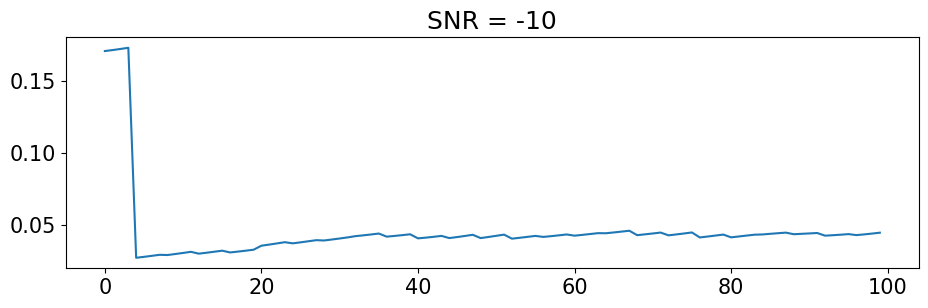

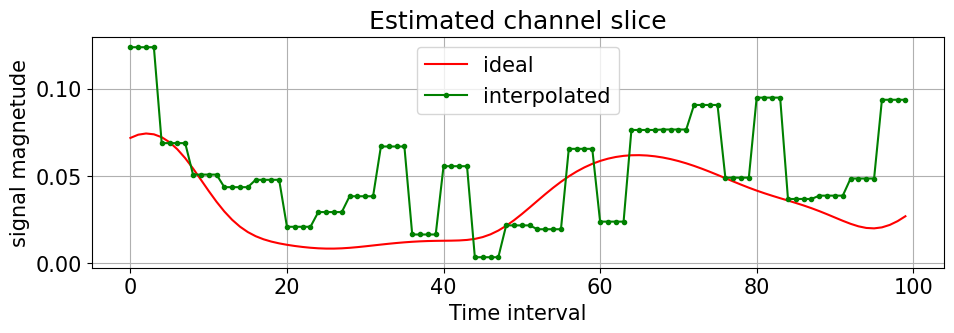

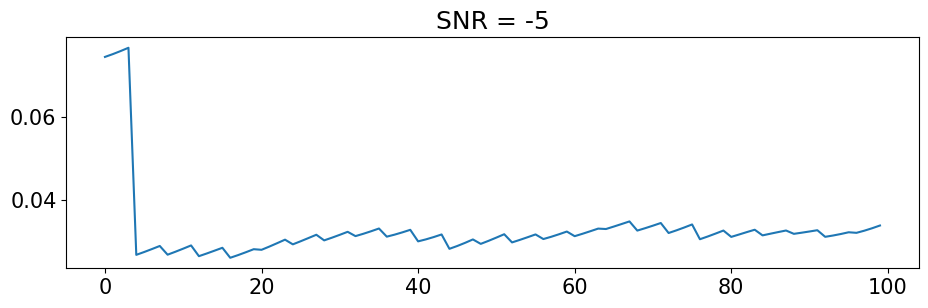

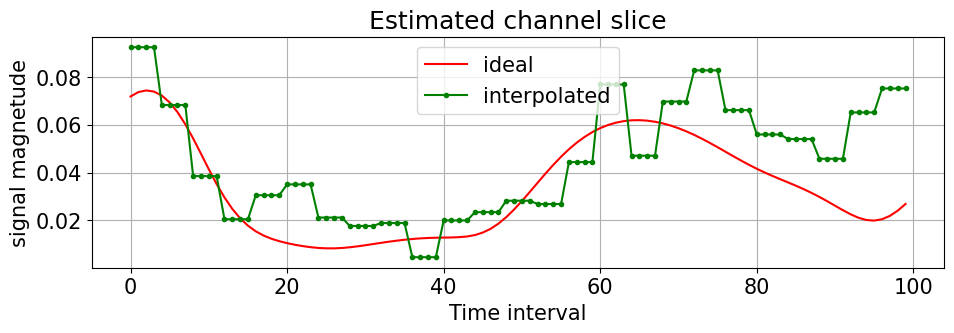

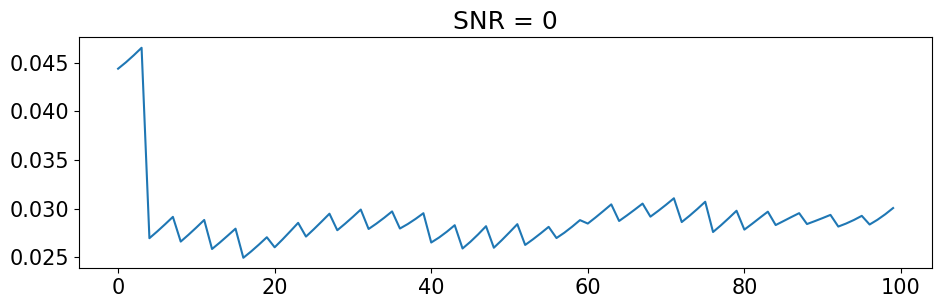

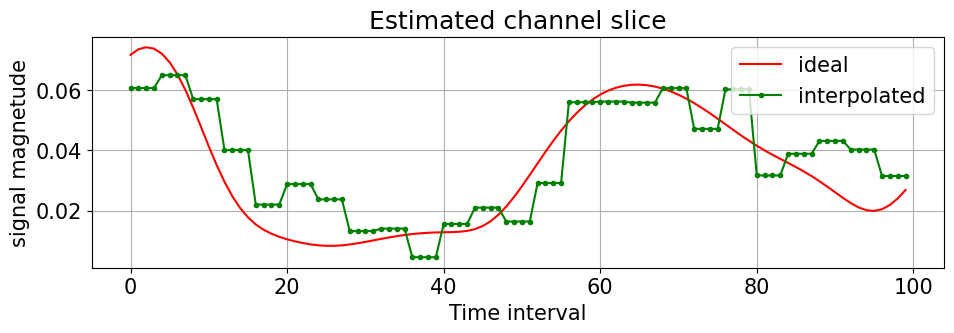

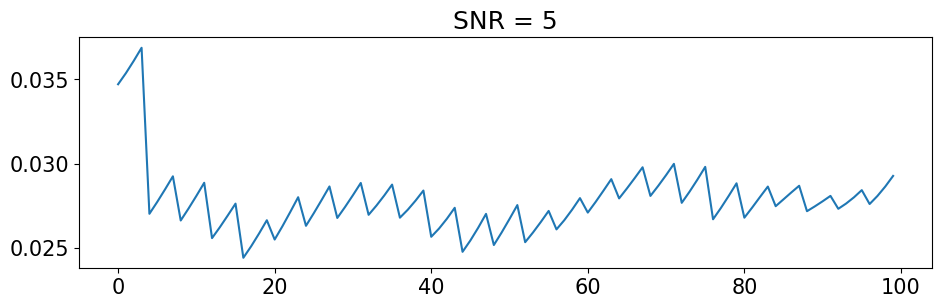

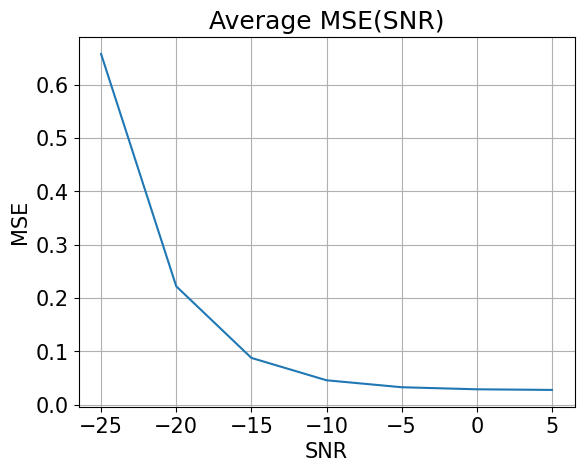

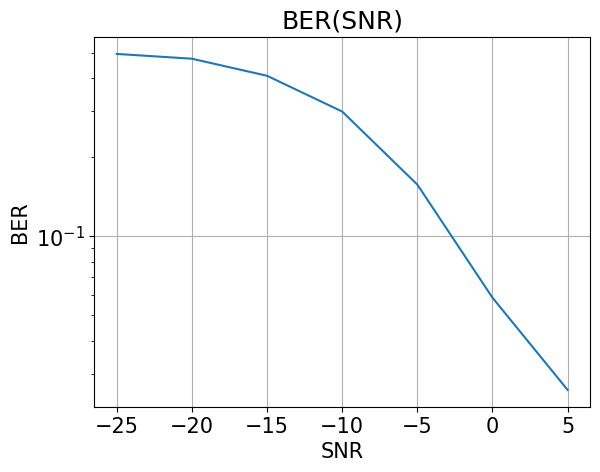

In [230]:
simulate(interp="previous", mem_size=8)

In [108]:
import concurrent.futures
import functools

def simulate_from_tuple(space_interpol_mem, H=H, to_plot=False):
    return simulate(H, *space_interpol_mem, to_plot=to_plot)

def grid_search():
    spacings = [4, 8, 12]
    mem_sizes = [2, 4, 6, 8]
    interps = ["previous", "linear", "quadratic", "cubic"]
    # spacings = [6]
    # mem_sizes = [1, 8]
    # interps = ["previous", "cubic"]
    parameter_grid = itertools.product(spacings, interps, mem_sizes)
    parameter_grid_copy = itertools.product(spacings, interps, mem_sizes)
    

    label_arr = []
    mse_avg_snr_arr = []
    ber_snr_arr = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
        for spacing_mem_size_interp, mse_vals_ber_arr in zip(parameter_grid, executor.map(simulate_from_tuple, parameter_grid_copy)):
            spacing, interp, mem_size = spacing_mem_size_interp
            mse_vals, ber_arr = mse_vals_ber_arr
            
            label_arr.append(f"spacing: {spacing}, {interp}, mem: {mem_size}")
            mse_avg_snr_arr.append(np.mean(mse_vals, axis=1))
            ber_snr_arr.append(ber_arr)
    
    snr_range = np.arange(-25, 10, 5)
    plt.figure()
    for label, mse_avg in zip(label_arr, mse_avg_snr_arr):
        plt.plot(snr_range, mse_avg, 'o-', label=label)
    plt.xlabel("SNR")
    plt.ylabel("MSE")
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()

    plt.figure()
    for label, ber_arr in zip(label_arr, ber_snr_arr):
        plt.plot(snr_range, ber_arr, 'o-', label=label)
    plt.xlabel("SNR")
    plt.ylabel("BER")
    plt.yscale('log')
    plt.grid()
    plt.legend(fontsize=10)
    plt.show()
    return label_arr, mse_avg_snr_arr, ber_snr_arr
    


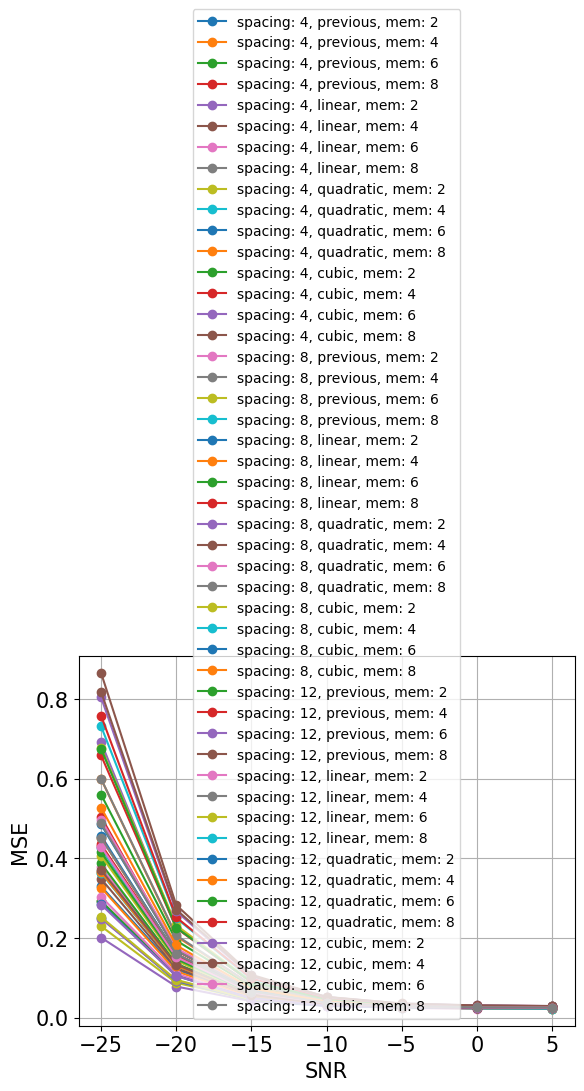

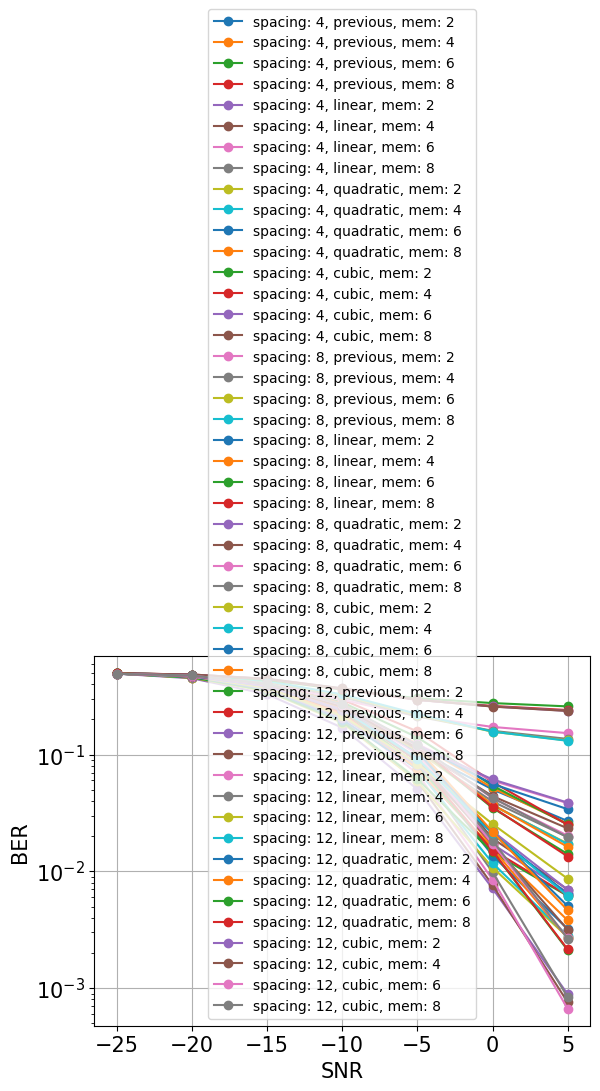

In [109]:
labels, mses, bers = grid_search()

<font color = 'darkred'>
Ваши задачи:

1.   Разработать описанный VAR фильтр
2.   Исследовать качество оценки канала VAR фильтра для разных показателей параметров `spacing_pilot`, `memory_size`, и функций интерполяций. Для этого вам нужно построить:

>🔮 <font color = 'darkred'> MSE (между идеальным и оценненым каналом) в зависимости от TTI усредненного для разных уровней шума (от -25 дБ до 10 дБ)

>🔮 <font color = 'darkred'>MSE vs SNR, усреднное по TTI

>✨ <font color = 'darkred'>Просимулировать передачу данных с использованией разработанной функцией оценки канала и построить кривые BER vs SNR

3. <font color = 'darkred'> Используя результаты из пункта 2, определить оптимальные значения параметров `spacing_pilot` и `memory_size` для канала "link_chan_2", а также придумать способ их нахождения для других видов каналов

4. <font color = 'darkred'> Попробуйте повторить свои результаты с использованием найденных значений из пункта 3, и постройте графики из пунтка 2 для каналов `PATH` и `SPEED`. Объясните свои результаты.

5. <font color = 'darkred'> Опишите свои результаты и предоставьте объяснения в отчете.




